In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

 ['#e1dd37', '#f4c73a', '#fdac34', '#fd8d27', '#f56918', '#e84b0c', '#d63506', '#bc2002', '#9e1001', '#7a0403']


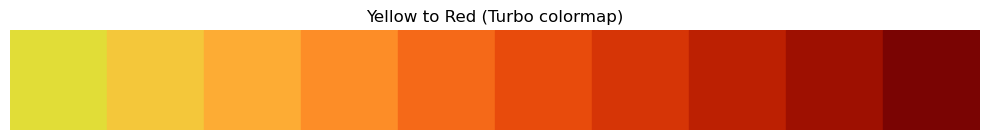

In [2]:
# Turbo colormap from matplotlib
cmap = plt.cm.turbo

# Define the range for yellow to red in Turbo (approx 0.6 to 1.0)
n_colors = 10
start, end = 0.6, 1.0
values = np.linspace(start, end, n_colors)

# Get RGB colors
colors = [cmap(v) for v in values]
hex_colors = [mcolors.to_hex(c) for c in colors]


print(f" {hex_colors}")

# Plot the colors
fig, ax = plt.subplots(figsize=(n_colors, 1.5))
for i, color in enumerate(colors):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
ax.set_xlim(0, n_colors)
ax.set_ylim(0, 1)
ax.axis('off')
plt.title("Yellow to Red (Turbo colormap)", fontsize=12)
plt.tight_layout()
plt.show()



# Plot memory and time barplot

In [3]:
SRCNN_W256 = pd.read_csv("srcnn/model_train_val_metrics/srcnn_model_W256_24h_batchsize8_samplesall_normalized.csv")

REDNet256 = pd.read_csv("autoencoder/model_train_val_metrics/REDNet256_24h_batchsize8_samplesall_normalized.csv")

SwinIR = pd.read_csv("transformer/model_train_val_metrics/SwinIR_24h_batchsize8_samplesall_normalized.csv")


In [4]:
SRCNN_W256

,epoch,max_memory_GiB,elapsed_time_sec,train_loss,val_loss
0,1,2.023716,161.865879,0.060512,0.010175
1,2,2.023716,262.966807,0.005442,0.003336
2,3,2.023716,363.198643,0.003526,0.003697
3,4,2.023716,463.774718,0.003226,0.002800
4,5,2.023716,564.487381,0.003064,0.002753
...,...,...,...,...,...
220,221,2.023716,28465.036833,0.001939,0.001605
221,222,2.023716,28553.868741,0.001939,0.001665
222,223,2.023716,28643.081482,0.001937,0.001521
223,224,2.023716,28733.072340,0.001937,0.001585


In [5]:
srcnn_time = SRCNN_W256["elapsed_time_sec"].values[-1] / 60 /60 #hours
srcnn_memory = SRCNN_W256["max_memory_GiB"].values[-1]
print(srcnn_memory)

rednet_time = REDNet256["elapsed_time_sec"].values[-1] / 60 /60 #hours
rednet_memory = REDNet256["max_memory_GiB"].values[-1]
print(rednet_memory)

swinir_time = SwinIR["elapsed_time_sec"].values[-1] / 60 /60 #hours
swinir_memory = SwinIR["max_memory_GiB"].values[-1]

elan_time = 24 # hours
elan_memory = 37.17814064025879

2.02371597290039
2.449896335601806


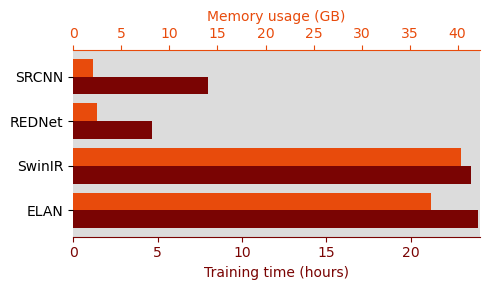

In [6]:

# Data
model_names = ["ELAN", "SwinIR", "REDNet", "SRCNN"]
times = [elan_time, swinir_time,rednet_time, srcnn_time]
memory = [elan_memory, swinir_memory,rednet_memory, srcnn_memory]

# Setup
fig, ax_time = plt.subplots(figsize=(5,3))
ax_memory = ax_time.twiny()
ax_time.set_facecolor("gainsboro")  

# Positions for bars
y_pos = range(len(model_names))

offset = 0.2  # Offset for memory bars

# Plot time bars (bottom)
time_color = hex_colors[9]
ax_time.barh([y - offset for y in y_pos], times, height=0.4, color=time_color, label="Time (s)")
ax_time.set_xlim([0, 24.1])
ax_time.set_xlabel("Training time (hours)", color=time_color)
ax_time.tick_params(axis='x', colors=time_color)
ax_time.spines['bottom'].set_color(time_color)
ax_time.set_yticks(y_pos)
ax_time.set_yticklabels(model_names)

# Plot memory bars (top)
memory_color = hex_colors[5]
ax_memory.barh([y + offset for y in y_pos], memory, height=0.4, color=memory_color, label="Memory (GiB)")
ax_memory.set_xlabel("Memory usage (GB)", color=memory_color)
ax_memory.tick_params(axis='x', colors=memory_color)
ax_memory.spines['top'].set_color(memory_color)
# # Hide unwanted spines
for side in ['top', 'left', 'right']:
    ax_time.spines[side].set_visible(False)
for side in ['bottom', 'left', 'right']:
    ax_memory.spines[side].set_visible(False)
# Title and layout
plt.tight_layout()
plt.savefig("final_figures/compare_time_and_memory.png", bbox_inches="tight")

plt.show()


In [12]:
for i in range(len(model_names)):
    print(f"{model_names[i]}: time = {times[i]}     memory = {memory[i]}")

ELAN: time = 24     memory = 37.17814064025879
SwinIR: time = 23.570044542484816     memory = 40.30909013748169
REDNet: time = 4.633061442375183     memory = 2.449896335601806
SRCNN: time = 8.007090284228324     memory = 2.02371597290039


# Plot visual comparison of all best models

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import torch.optim as optim
import torch.nn as nn
from srcnn.srcnn_model import SRCNN_W256, SRCNN
from autoencoder.autoencoder_model import REDNet10_W256
from transformer.transformer_model import ELAN
from transformer.swinir_model import SwinIR
from VAE.vae_model import REDNetVAE
from GAN.vae_gan_model import REDNetVAEGenerator
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))
from lib.utils import get_split_datapaths, psnr, init_logging
from lib.dataloader import PassiveMicrowaveDataset
import torch
from torch.utils.data import Dataset, DataLoader
import xarray as xr
import numpy as np
import cv2
from torchvision.transforms import ToTensor

from datetime import datetime

/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
train_paths, val_paths, test_paths = get_split_datapaths()

2025-05-23 10:23:10,363 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/11 does not exist. Skipping...
2025-05-23 10:23:10,364 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2011/12 does not exist. Skipping...
2025-05-23 10:23:10,365 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/01 does not exist. Skipping...
2025-05-23 10:23:10,365 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/02 does not exist. Skipping...
2025-05-23 10:23:10,366 - root - INFO - Warning: Directory /lustre/storeB/project/metkl/DigitalSeaIce/are-phd/SuperResolutionSeaIce/Dataset/AMSRSSMI/2012/03 does not exist. Skipping...
2025-05-23 10:23:10,366 - root - INFO - Warning: Directory /lustre/storeB/p

In [9]:
# Initialize test dataset with normalization
test_dataset = PassiveMicrowaveDataset(test_paths, transform=ToTensor(), normalize=True, use_bicubic=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [10]:
"""
NE arctic ocean [50:250,100:300]

svalbard and ice edge [180:380,180:380]
"""
plt.rcParams.update({'font.size': plt.rcParams['font.size'] + 2})


def plot_model_compare(model_pth1, model1, 
                       model_pth2, model2,
                       model_pth3, model3,
                       model_pth4, model4,
                       test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    # dt.strftime("%Y-%m-%d %H:00")
    print(str(dt).split(' ')[0])

    model1.load_state_dict(torch.load(model_pth1, map_location=torch.device("cpu")))
    model1.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        output = model1(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output1 = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output1 = output.squeeze(0).cpu().numpy()

    #### model 2 #####
    model2.load_state_dict(torch.load(model_pth2, map_location=torch.device("cpu")))
    model2.eval()  # Set the model to evaluation mode
    # Run model inference
    with torch.no_grad():
        output = model2(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output2 = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output2 = output.squeeze(0).cpu().numpy()


    #### model 3 ####
    model3.load_state_dict(torch.load(model_pth3, map_location=torch.device("cpu")))
    model3.eval()  # Set the model to evaluation mode
    # Run model inference
    with torch.no_grad():
        output = model3(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output3 = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output3 = output.squeeze(0).cpu().numpy()

        #### model 4 ####
    model4.load_state_dict(torch.load(model_pth4, map_location=torch.device("cpu")))
    model4.eval()  # Set the model to evaluation mode
    # Run model inference
    with torch.no_grad():
        output = model4(low_res_tensor)

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output4 = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output4 = output.squeeze(0).cpu().numpy()


    ##################################################################

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)



    fig, axs = plt.subplots(2, 6, figsize=(14.8, 4.8))
    
    cmap_color =  'turbo'
    # V-pol comparison
    im1 = axs[0, 0].imshow(low_res[0], cmap=cmap_color, vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("Low-Res Input")
    # axs[0, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_v:.3f}\nSSIM: {ssim_low_res_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 0].transAxes)

    im2 = axs[0, 1].imshow(high_res[0], cmap=cmap_color, vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("High-Res Ground Truth")

    im3 = axs[0, 2].imshow(output1[0], cmap=cmap_color, vmin=v_min, vmax=v_max)  # SRCNN Output
    axs[0, 2].axis('off')
    axs[0, 2].set_title("SRCNN")
    # axs[0, 2].text(0.7, 0.9, f"PSNR: {psnr_value_v:.3f}\nSSIM: {ssim_output_v:.3f}", color='white', ha='left', va='bottom', transform=axs[0, 2].transAxes)

    im31 = axs[0, 3].imshow(output2[0], cmap=cmap_color, vmin=v_min, vmax=v_max)  # AE Output
    axs[0, 3].axis('off')
    axs[0, 3].set_title("REDNet")

    im32 = axs[0, 4].imshow(output3[0], cmap=cmap_color, vmin=v_min, vmax=v_max)  # Transf Output
    axs[0, 4].axis('off')
    axs[0, 4].set_title("SwinIR")

    im33 = axs[0, 5].imshow(output4[0], cmap=cmap_color, vmin=v_min, vmax=v_max)  # VAE Output
    axs[0, 5].axis('off')
    axs[0, 5].set_title("ELAN")

    # H-pol comparison
    im4 = axs[1, 0].imshow(low_res[1], cmap=cmap_color, vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")
    # axs[1, 0].text(0.7, 0.9, f"PSNR: {psnr_baseline_h:.3f}\nSSIM: {ssim_low_res_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 0].transAxes)

    im5 = axs[1, 1].imshow(high_res[1], cmap=cmap_color, vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")

    im6 = axs[1, 2].imshow(output1[1], cmap=cmap_color, vmin=h_min, vmax=h_max)  # SRCNN Output
    axs[1, 2].axis('off')
    axs[1, 2].set_title("")
    # axs[1, 2].text(0.7, 0.9, f"PSNR: {psnr_value_h:.3f}\nSSIM: {ssim_output_h:.3f}", color='white', ha='left', va='bottom', transform=axs[1, 2].transAxes)

    im61 = axs[1, 3].imshow(output2[1], cmap=cmap_color, vmin=h_min, vmax=h_max)  # AE Output
    axs[1, 3].axis('off')
    axs[1, 3].set_title("")

    im62 = axs[1, 4].imshow(output3[1], cmap=cmap_color, vmin=h_min, vmax=h_max)  # Transf Output
    axs[1, 4].axis('off')
    axs[1, 4].set_title("")

    im63 = axs[1, 5].imshow(output3[1], cmap=cmap_color, vmin=h_min, vmax=h_max)  # VAE Output
    axs[1, 5].axis('off')
    axs[1, 5].set_title("")



    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.400])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.03, 0.02, 0.400])  # Bottom row
    fig.colorbar(im2, cax=cbar_ax1, label=' ')
    fig.colorbar(im5, cax=cbar_ax2, label=' ')

    # Add a shared label in the middle manually
    fig.text(0.95, 0.5, 'Brightness Temperature (K)', va='center', rotation=90)
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])
    # plt.show()

/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


2020-02-16


/tmp/ipykernel_4014020/4228400145.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(model_pth1, map_location=torch.device("cpu")))
/tmp/

2025-05-23 10:23:51,072 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fbd94771cd0>
2025-05-23 10:23:51,077 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fbd94795250>
2025-05-23 10:23:51,089 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.
2025-05-23 10:23:51,090 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-23 10:23:51,090 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal'

/tmp/ipykernel_4014020/4228400145.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


2025-05-23 10:23:51,824 - matplotlib.backends.backend_pdf - DEBUG - Assigning font /F1 = '/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-23 10:23:51,983 - matplotlib.backends.backend_pdf - DEBUG - Embedding font /home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-23 10:23:51,983 - matplotlib.backends.backend_pdf - DEBUG - Writing TrueType font.


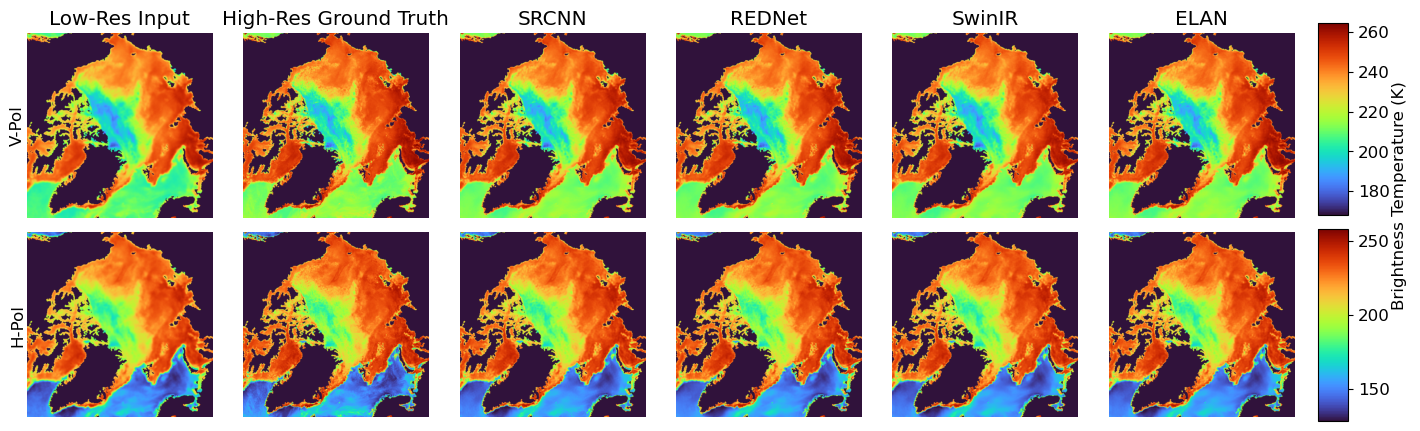

In [11]:
plot_model_compare(model_pth1= "srcnn/trained_models/srcnn_model_W256_24h_batchsize8_samplesall_normalized.pth",
                model1 = SRCNN_W256(),
                model_pth2= "autoencoder/trained_models/REDNet256_24h_batchsize8_samplesall_normalized.pth",
                model2 = REDNet10_W256(),
                model_pth3= "transformer/trained_models/SwinIR_24h_batchsize8_samplesall_normalized.pth",
                model3 = SwinIR( img_size=416,
                        in_chans=2,
                        upscale=1,
                        window_size=4, 
                        upsampler=None,  
                        img_range=1.0,
                        embed_dim=24,
                        num_heads=[4, 4, 4, 4]
                        ),
                model_pth4= "transformer/trained_models/ELAN_light1_24h_batchsize8_samplesall_normalized.pth",
                model4 = ELAN(),
                test_paths=test_paths,
                test_dataset=test_dataset,
                denormalize = True,
                sample_idx=40)
plt.savefig("final_figures/compare_models_full_domain.pdf", bbox_inches="tight")


2020-02-16


/tmp/ipykernel_2141800/359832363.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(model_pth1, map_location=torch.device("cpu")))
/tmp/i

2025-05-23 10:13:49,250 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fab17aaa000>
2025-05-23 10:13:49,255 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fab17a810d0>
2025-05-23 10:13:49,267 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999.
2025-05-23 10:13:49,269 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-05-23 10:13:49,269 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal'

/tmp/ipykernel_2141800/359832363.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


2025-05-23 10:13:49,518 - matplotlib.backends.backend_pdf - DEBUG - Assigning font /F1 = '/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-05-23 10:13:49,597 - matplotlib.backends.backend_pdf - DEBUG - Embedding font /home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-23 10:13:49,598 - matplotlib.backends.backend_pdf - DEBUG - Writing TrueType font.


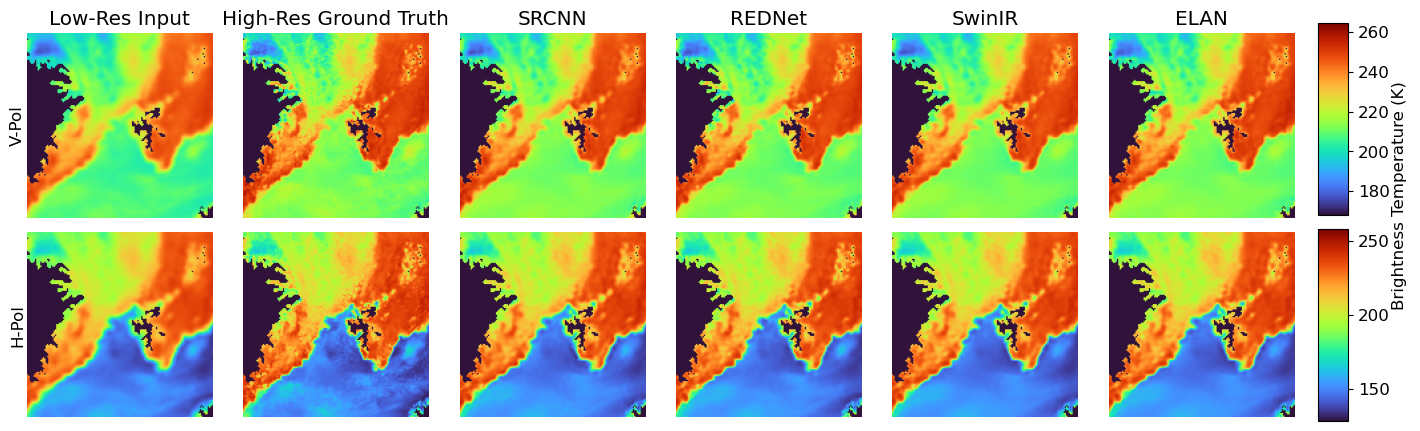

In [14]:
plot_model_compare(model_pth1= "srcnn/trained_models/srcnn_model_W256_24h_batchsize8_samplesall_normalized.pth",
                model1 = SRCNN_W256(),
                model_pth2= "autoencoder/trained_models/REDNet256_24h_batchsize8_samplesall_normalized.pth",
                model2 = REDNet10_W256(),
                model_pth3= "transformer/trained_models/SwinIR_24h_batchsize8_samplesall_normalized.pth",
                model3 = SwinIR( img_size=416,
                        in_chans=2,
                        upscale=1,
                        window_size=4, 
                        upsampler=None,  
                        img_range=1.0,
                        embed_dim=24,
                        num_heads=[4, 4, 4, 4]
                        ),
                model_pth4= "transformer/trained_models/ELAN_light1_24h_batchsize8_samplesall_normalized.pth",
                model4 = ELAN(),
                test_paths=test_paths,
                test_dataset=test_dataset,
                denormalize = True,
                sample_idx=40)
plt.savefig("final_figures/compare_models_svalbard.pdf", bbox_inches="tight")


# VAE and VAE-GAN

In [23]:

def plot_prob_model_compare(model_pth1, model1, 
                       model_pth2, model2,
                       test_paths, test_dataset, sample_idx, device="cuda" if torch.cuda.is_available() else "cpu", denormalize = True):
    """
    Plot a single test sample's low-resolution input, high-resolution ground truth, 
    and model output.
    """
    time = test_paths[sample_idx].split("_")[-1].replace(".nc","")
    dt = datetime.strptime(str(time), "%Y%m%d%H")
    # dt.strftime("%Y-%m-%d %H:00")
    print(str(dt).split(' ')[0])

    model1.load_state_dict(torch.load(model_pth1, map_location=torch.device("cpu")))
    model1.eval()  # Set the model to evaluation mode

    # Get a single test sample
    low_res, high_res = test_dataset[sample_idx]

    # Convert to batch format and move to device
    low_res_tensor = low_res.clone().detach().unsqueeze(0).to(device)
    high_res_tensor = high_res.clone().detach().unsqueeze(0).to(device)

    # Run model inference
    with torch.no_grad():
        output = model1(low_res_tensor)[0]

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output1 = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output1 = output.squeeze(0).cpu().numpy()

    #### model 2 #####
    model2.load_state_dict(torch.load(model_pth2, map_location=torch.device("cpu")))
    model2.eval()  # Set the model to evaluation mode
    # Run model inference
    with torch.no_grad():
        output = model2(low_res_tensor)[0]

    # Move data back to CPU and convert to NumPy
    if denormalize:
        low_res = test_dataset.denormalize(low_res_tensor.squeeze(0)).cpu().numpy()
        high_res = test_dataset.denormalize(high_res_tensor.squeeze(0)).cpu().numpy()
        output2 = test_dataset.denormalize(output.squeeze(0)).cpu().numpy()
    else:
        low_res = low_res_tensor.squeeze(0).cpu().numpy()
        high_res = high_res_tensor.squeeze(0).cpu().numpy()
        output2 = output.squeeze(0).cpu().numpy()


    ##################################################################

    filtered_low_res_v = low_res[0][low_res[0] > 0]
    filtered_high_res_v = high_res[0][high_res[0] > 0]
    combined_filtered_v = np.concatenate([filtered_low_res_v, filtered_high_res_v])
    v_min = np.min(combined_filtered_v)
    v_max = np.max(combined_filtered_v)

    filtered_low_res_h = low_res[1][low_res[1] > 0]
    filtered_high_res_h = high_res[1][high_res[1] > 0]
    combined_filtered_h = np.concatenate([filtered_low_res_h, filtered_high_res_h])
    h_min = np.min(combined_filtered_h)
    h_max = np.max(combined_filtered_h)



    fig, axs = plt.subplots(2, 2, figsize=(6.4, 6.4))
    plt.rcParams.update({'font.size': plt.rcParams['font.size'] - 2})


    cmap_color =  'turbo'
    # V-pol comparison
    im1 = axs[0, 0].imshow(output1[0], cmap=cmap_color, vmin=v_min, vmax=v_max)
    axs[0, 0].axis('off')
    axs[0, 0].set_title("VAE")

    im2 = axs[0, 1].imshow(output2[0], cmap=cmap_color, vmin=v_min, vmax=v_max)  # Ground Truth
    axs[0, 1].axis('off')
    axs[0, 1].set_title("VAE-GAN")

    # H-pol comparison
    im4 = axs[1, 0].imshow(output1[1], cmap=cmap_color, vmin=h_min, vmax=h_max)
    axs[1, 0].axis('off')
    axs[1, 0].set_title("")

    im5 = axs[1, 1].imshow(output2[1], cmap=cmap_color, vmin=h_min, vmax=h_max)  # Ground Truth
    axs[1, 1].axis('off')
    axs[1, 1].set_title("")


    axs[0, 0].annotate("V-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)
    axs[1, 0].annotate("H-Pol", xy=(-0.05, 0.5), xycoords='axes fraction', fontsize=12, ha='center', va='center', rotation=90)

    # Add colorbars outside the plot
    cbar_ax1 = fig.add_axes([0.9, 0.46, 0.02, 0.400])  # Top row
    cbar_ax2 = fig.add_axes([0.9, 0.03, 0.02, 0.400])  # Bottom row
    fig.colorbar(im2, cax=cbar_ax1, label=' ')
    fig.colorbar(im5, cax=cbar_ax2, label=' ')

    # Add a shared label in the middle manually
    fig.text(0.99, 0.5, 'Brightness Temperature (K)', va='center', rotation=90)
    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0, .9, .92])
    # plt.show()

2020-02-16


/tmp/ipykernel_2141800/2922322343.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load(model_pth1, map_location=torch.device("cpu")))
/tmp/

2025-05-23 10:21:27,628 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fab17936ea0>
2025-05-23 10:21:27,633 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7fab178da9f0>
2025-05-23 10:21:27,788 - matplotlib.backends.backend_pdf - DEBUG - Assigning font /F1 = '/home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'


/tmp/ipykernel_2141800/2922322343.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, .92])


2025-05-23 10:21:27,852 - matplotlib.backends.backend_pdf - DEBUG - Embedding font /home/alessioc/.conda/envs/FYS5429/lib/python3.12/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-05-23 10:21:27,853 - matplotlib.backends.backend_pdf - DEBUG - Writing TrueType font.


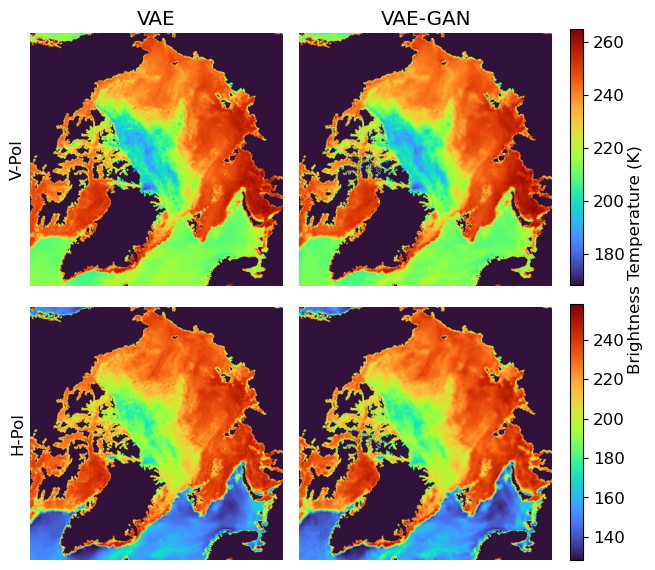

In [24]:
plot_prob_model_compare(model_pth1= "VAE/trained_models/REDNetVAE_24h_batch8_samplesall.pth",
                model1 = REDNetVAE(),
                model_pth2= "GAN/trained_models/gen_REDNetVAEGAN_batch8_samplesall.pth",
                model2 = REDNetVAEGenerator(),
                test_paths=test_paths,
                test_dataset=test_dataset,
                denormalize = True,
                sample_idx=40)
plt.savefig("final_figures/compare_VAE_VAEGAN.pdf", bbox_inches="tight")